<a href="https://colab.research.google.com/github/teruyo14/Classification-of-CIFAR10-with-Major-CNNs-and-Visualization-with-t-SNE/blob/main/Classification_of_CIFAR10_with_DLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Papers: Deep Layer Aggregation  
https://arxiv.org/pdf/1707.06484.pdf

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import copy
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 48994527.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.InstanceNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.InstanceNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.InstanceNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.InstanceNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(32),
            nn.ReLU(True)
        )

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.1)
        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x, return_embed=False):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.dropout1(out)
        out = self.layer3(out)
        out = self.dropout2(out)
        out = self.layer4(out)
        out = self.dropout2(out)
        out = self.layer5(out)
        out = self.dropout2(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        if return_embed:
            return out
        out = self.linear(out)
        return out

    def get_device(self):
        return self.linear.weight.device

    def copy(self):
        return copy.deepcopy(self)

In [ ]:
model = DLA()
model.to(device)

DLA(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (layer3): Tree(
    (root): Root(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_st

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.0003)

In [ ]:
def plot_t_sne(data_loader, model,num_samples):
    model.eval()

    # Formatting data for t-SNE
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # Extracting features
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # To Numpy Array
    x = x.numpy()
    y = y.numpy()

    # Extract a specified number of samples
    x = x[:num_samples]
    y = y[:num_samples]

    # Apply t-SNE
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # Set color and marker for each label
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # Plot data
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')

    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.title("Model:Deep Layer Aggregation", fontsize = 70, y = -0.1)
    plt.show()

epoch: 1, loss: 2.193816550857271, acc: 0.18022698163986206,      val loss: 1.986162018852112, val acc: 0.2730630934238434
epoch: 2, loss: 1.7484677046766062, acc: 0.3851102888584137,      val loss: 1.5207696166663125, val acc: 0.47643768787384033
epoch: 3, loss: 1.4027623288771685, acc: 0.5137068629264832,      val loss: 1.2749109498608988, val acc: 0.5585063695907593
epoch: 4, loss: 1.1570812837242166, acc: 0.6061580777168274,      val loss: 1.068279595039904, val acc: 0.640674889087677
epoch: 5, loss: 0.972495742389918, acc: 0.6728740334510803,      val loss: 0.9132695494178004, val acc: 0.6952875256538391
epoch: 6, loss: 0.8491817747845369, acc: 0.7162523865699768,      val loss: 0.8399927592315612, val acc: 0.7237420082092285
epoch: 7, loss: 0.7576322497995308, acc: 0.7474624514579773,      val loss: 0.7145959049368057, val acc: 0.7624800205230713
epoch: 8, loss: 0.6916447482679201, acc: 0.7696011662483215,      val loss: 0.7440920173169706, val acc: 0.7506988644599915
epoch: 9, l

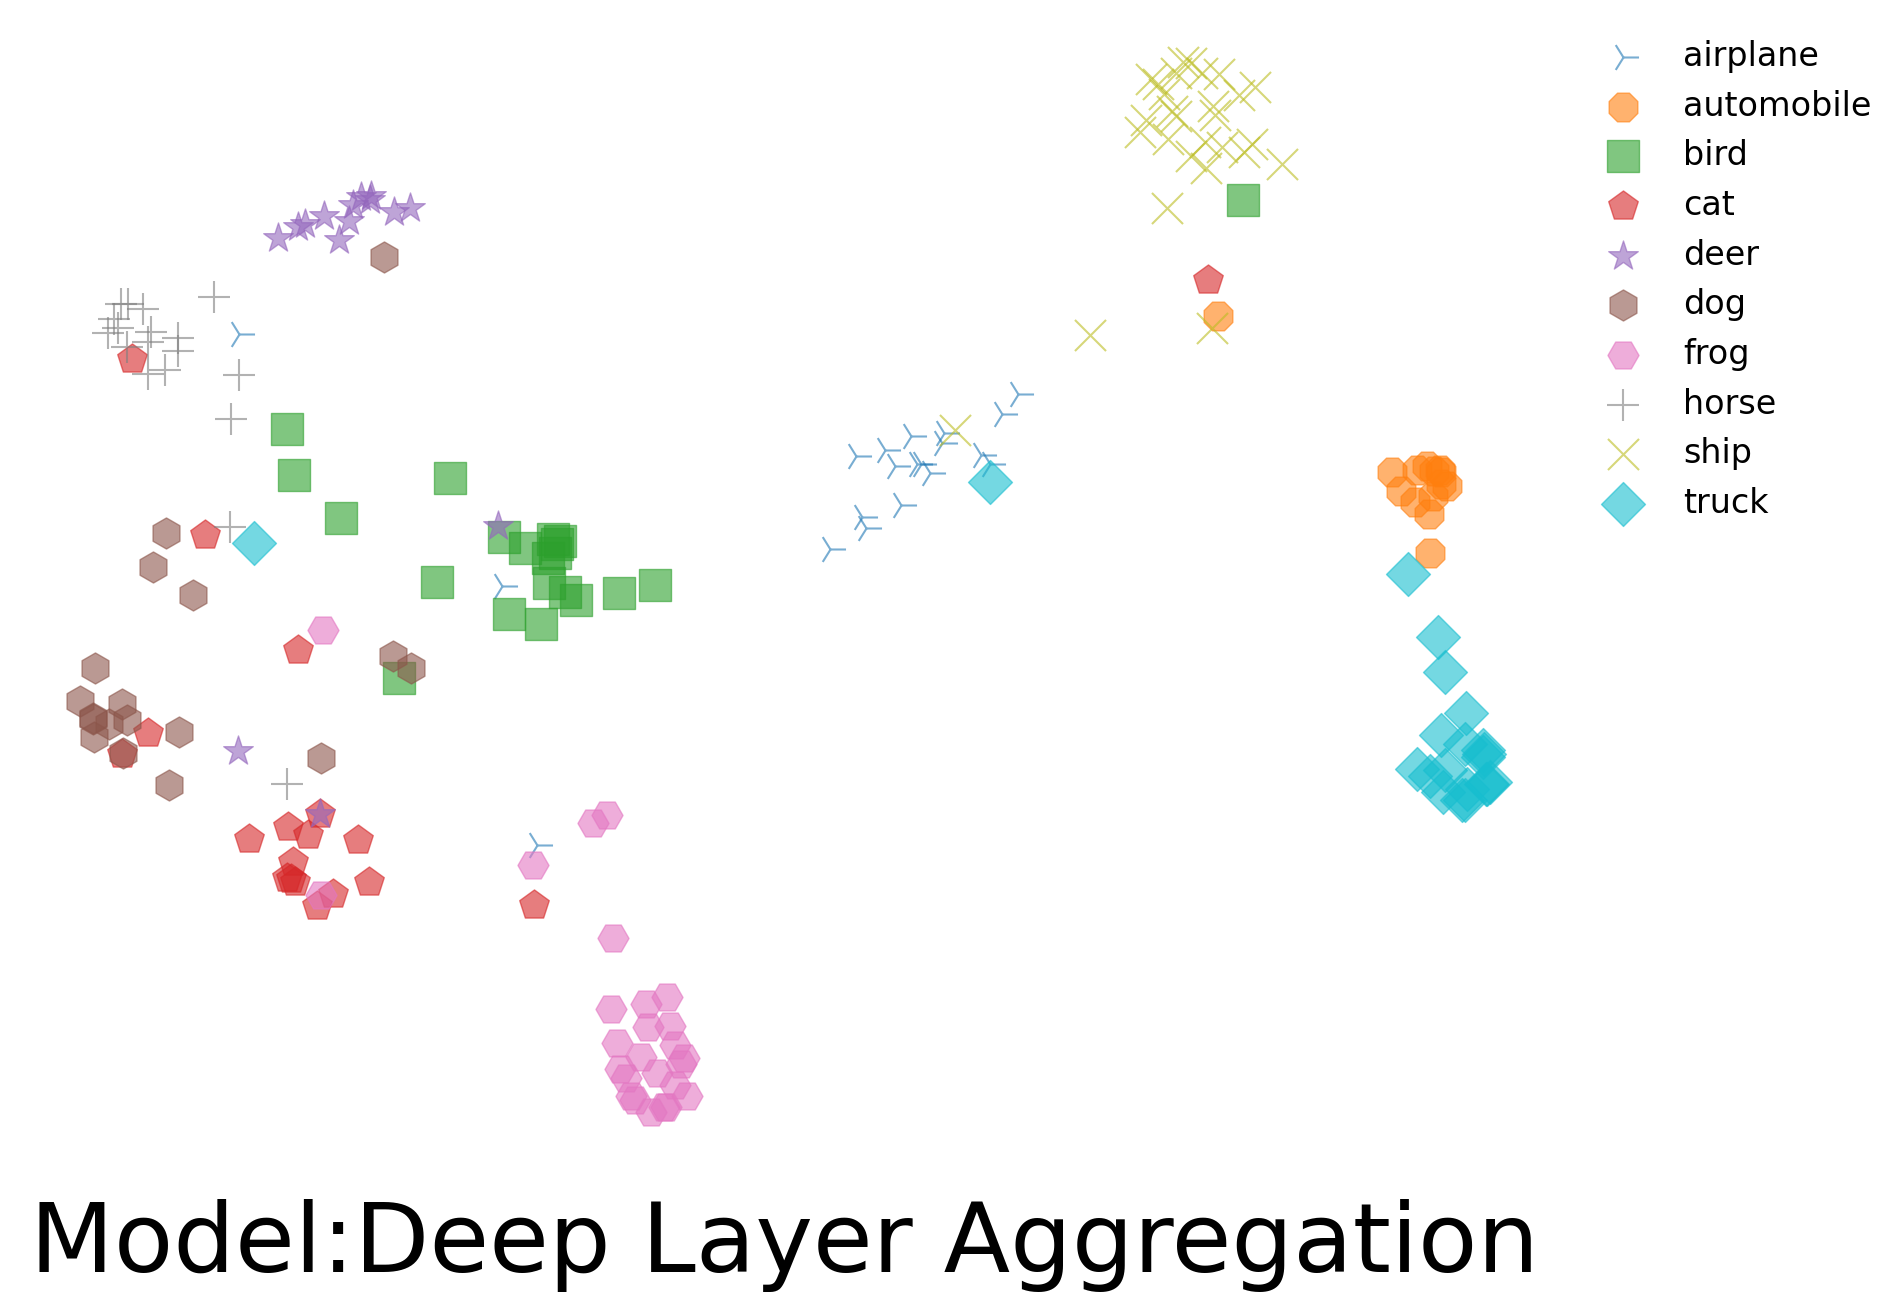

In [ ]:
num_epochs = 20
num_samples = 200
losses = []
accs = []
val_losses = []
val_accs = []
val_acc_best = 0.0
model_best = None
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc.item())
    #
    # validation loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    model.eval()
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc.item())
    if val_running_acc > val_acc_best:
            val_acc_best = val_running_acc.item()
            model_best = model.copy()
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc))

# Plot distribution of features using t-SNE
plot_t_sne(validation_dataloader, model_best, num_samples)

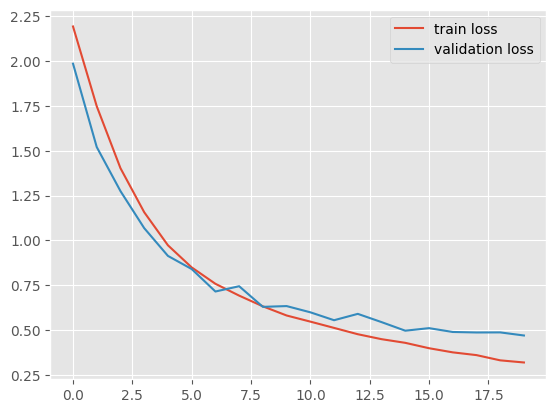

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

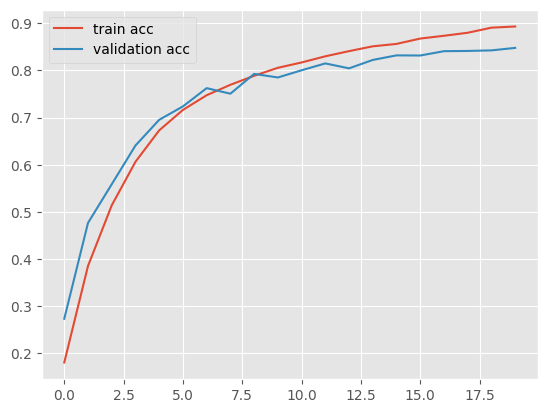

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()